imports

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix


Read the files

In [16]:
first_df = pd.read_csv('../data/heart_first_dataset.csv')
second_df = pd.read_csv('../data/heart_second_dataset.csv')
print(first_df.columns)
print(second_df.columns)

Index(['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach',
       'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target'],
      dtype='object')
Index(['age', 'sex', 'cp', 'trtbps', 'chol', 'fbs', 'restecg', 'thalachh',
       'exng', 'oldpeak', 'slp', 'caa', 'thall', 'output'],
      dtype='object')


Do one dataset with both

In [17]:
#as we can see the dataset have the same columns, but not name exactly the same way
#we will rename the columns to have the same name and concatenate the two datasets
first_df = first_df.rename(columns={"target":"output"})
second_df = second_df.rename(columns={"trtbps":"trestbps",
                                      "thalachh":"thalach",
                                      "exng":"exang",
                                      "slp":"slope",
                                      "caa":"ca",
                                      "thall":"thal",
                                      "target":"output"})
print(first_df.columns)
print(second_df.columns)
print(first_df.shape)
print(second_df.shape)
new_df = pd.concat([first_df, second_df], ignore_index=True)
print(new_df.shape)
new_df.to_csv('../data/heart_dataset.csv', index=False)

Index(['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach',
       'exang', 'oldpeak', 'slope', 'ca', 'thal', 'output'],
      dtype='object')
Index(['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach',
       'exang', 'oldpeak', 'slope', 'ca', 'thal', 'output'],
      dtype='object')
(1025, 14)
(303, 14)
(1328, 14)


explore the data

In [18]:
new_df.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,output
count,1328.000000,1328.000000,1328.000000,1328.000000,1328.000000,1328.000000,1328.000000,1328.000000,1328.000000,1328.000000,1328.000000,1328.000000,1328.000000,1328.000000
mean,54.418675,0.692771,0.948042,131.614458,246.060241,0.149096,0.529367,149.235693,0.334337,1.064232,1.388554,0.748494,2.321536,0.520331
std,9.071150,0.461519,1.029854,17.514997,51.627522,0.356318,0.527220,22.975286,0.471936,1.171519,0.617203,1.028603,0.618543,0.499775
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,48.000000,0.000000,0.000000,120.000000,211.000000,0.000000,0.000000,132.000000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,56.000000,1.000000,1.000000,130.000000,240.000000,0.000000,1.000000,152.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,275.000000,0.000000,1.000000,166.000000,1.000000,1.800000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


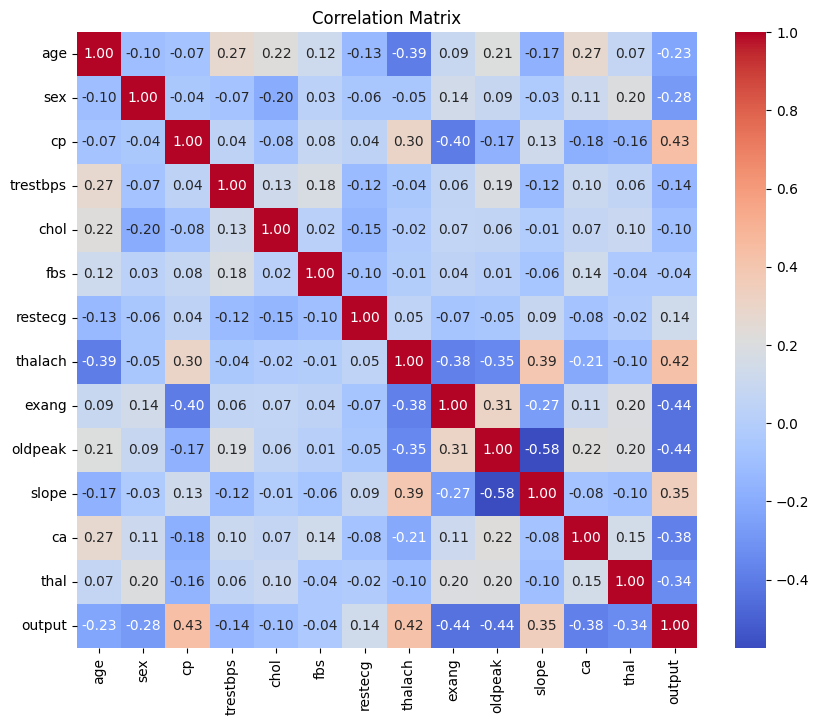

In [19]:
#correlation matrix
corr_matrix = new_df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix,annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

In [20]:
#correlation with the output
corr_matrix = corr_matrix.drop('output')
corr_with_output = corr_matrix['output'].sort_values(ascending=False)
print(corr_with_output)


cp          0.434704
thalach     0.422724
slope       0.345709
restecg     0.135011
fbs        -0.038194
chol       -0.096515
trestbps   -0.140117
age        -0.228442
sex        -0.280008
thal       -0.339286
ca         -0.384375
oldpeak    -0.436815
exang      -0.437802
Name: output, dtype: float64


# Machine learning

output: 0 = no disease, 1 = disease

## Training part

split the data

In [21]:
X = new_df.drop('output', axis=1)
y = new_df['output']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234567)


We need to know one sample of each type of output in order to label the prediction

In [22]:
#for this we will need an id column
X_train['id'] = X_train.index
id_disease = X_train[y_train == 1]['id']
id_no_disease = X_train[y_train == 0]['id']

#in order to be able to label the cluster after
id_column = X_train['id']
X_train = X_train.drop('id', axis=1)

Kmeans

0.0
1.0


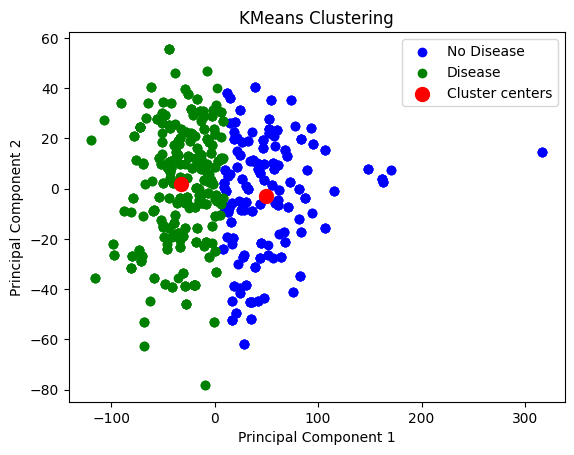

In [23]:
#before doing the clustering we need to do a PCA to reduce the dimensionality of the dataset
pca = PCA(n_components=2)


X_train_pca = pca.fit_transform(X_train)
kmeans = KMeans(n_clusters=2)
kmeans.fit(X_train_pca)
y_pred_with_kmeans = kmeans.predict(X_train_pca)

#detect which cluster is the one with the sample_no_disease
X_train_pca = pd.DataFrame(X_train_pca, columns=['Principal Component 1', 'Principal Component 2'])
#join the X_train_pca with the id column and the y_pred_with_kmeans
X_train_pca_final_pred_with_kmeans = pd.concat([X_train_pca, id_column, pd.Series(y_pred_with_kmeans, name='cluster')], axis=1)

output_no_disease = X_train_pca_final_pred_with_kmeans[X_train_pca_final_pred_with_kmeans['id'].isin(id_no_disease)]['cluster'].iloc[0]
print(output_no_disease)
output_disease = X_train_pca_final_pred_with_kmeans[X_train_pca_final_pred_with_kmeans['id'].isin(id_disease)]['cluster'].iloc[0]
print(output_disease)

cluster_no_disease = X_train_pca_final_pred_with_kmeans[X_train_pca_final_pred_with_kmeans['cluster'] == output_no_disease]
cluster_disease = X_train_pca_final_pred_with_kmeans[X_train_pca_final_pred_with_kmeans['cluster'] == output_disease]
# Plotting the clusters
plt.scatter(cluster_no_disease['Principal Component 1'], cluster_no_disease['Principal Component 2'], 
            label='No Disease', c='blue')
plt.scatter(cluster_disease['Principal Component 1'], cluster_disease['Principal Component 2'], 
            label='Disease', c='green')

# Plotting the cluster centers
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=100, alpha=1, label='Cluster centers')

# Adding labels and legend
plt.title('KMeans Clustering')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()


XGBoost

In [24]:
parameters = {
        "eta": [0.001, 0.01, 0.05, 0.1, 0.3, 0.5],
        "gamma": [0, 0.1, 0.5, 1, 3, 5],
        "max_depth": [5, 10, 15, 25, 50, 100],
        "min_child_weight": [1, 3, 5, 10, 20, 30],
        "subsample": [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 1],
        "lambda": [0, 1, 2, 5, 10, 20],
        "alpha": [0, 0.1, 0.5, 1, 5, 10],
        "objective": ["binary:logistic","binary:logitraw"],
    }

xgb_model = xgb.XGBClassifier()
n_iter_search = 1000
random_search = RandomizedSearchCV(xgb_model, param_distributions=parameters, n_iter=n_iter_search, scoring='neg_mean_squared_error', cv=5, n_jobs=-1)
random_search.fit(X_train, y_train)
print(random_search.best_params_)
print(random_search.best_score_)
y_pred_with_xgb = random_search.predict(X_test)

{'subsample': 0.5, 'objective': 'binary:logistic', 'min_child_weight': 1, 'max_depth': 50, 'lambda': 0, 'gamma': 0.1, 'eta': 0.3, 'alpha': 0.5}
-0.009425104083621225


c:\Users\mathy\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


## Results parts

let's compare the efficency using: accuracy,precision, recall and f1-score

[1 0 0 ... 0 0 1]
[0 1 0 0 1 1 1 1 1 1 1 1 0 0 1 1 0 1 1 1 1 0 0 0 1 1 0 0 1 1 0 0 1 1 0 1 1
 1 1 1 0 1 0 0 0 0 0 1 1 1 1 0 0 1 1 1 1 1 1 0 1 0 1 0 0 0 1 1 1 1 0 0 1 0
 1 1 1 0 1 0 1 1 0 0 1 0 1 1 0 1 1 0 1 1 1 0 1 0 0 1 0 1 1 0 0 1 0 1 0 0 0
 0 0 1 0 0 0 0 1 1 1 0 0 1 1 0 0 0 1 0 1 1 1 1 0 0 1 0 0 1 0 1 0 0 0 0 0 0
 0 1 0 0 1 0 1 0 1 1 1 1 0 0 0 1 0 1 0 1 0 1 1 1 0 1 0 1 1 1 0 0 0 0 0 0 0
 1 0 0 1 1 0 0 0 0 0 0 1 1 1 1 0 0 0 0 1 0 0 1 1 0 0 1 0 0 1 0 1 0 0 1 1 0
 0 0 1 1 0 0 1 0 0 1 1 1 1 1 0 0 0 1 1 1 1 1 0 0 0 0 1 0 1 1 1 1 1 1 0 1 1
 0 0 0 1 1 1 1]


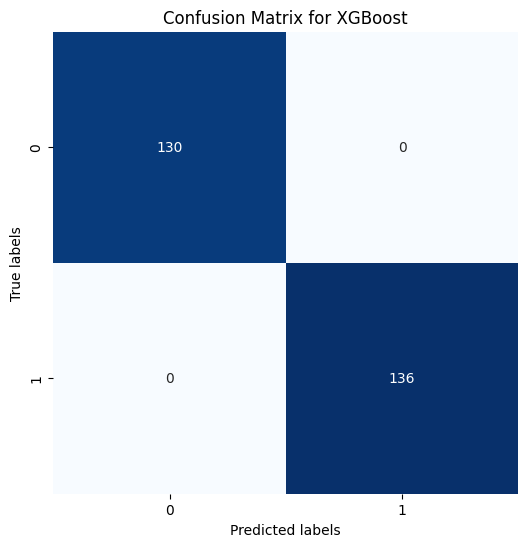

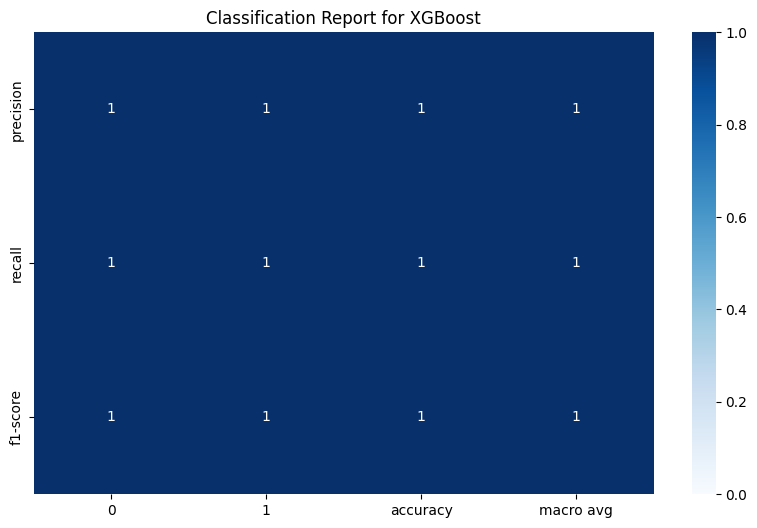

ValueError: Found input variables with inconsistent numbers of samples: [266, 1062]

In [26]:
print(y_pred_with_kmeans)
print(y_pred_with_xgb)
def plot_confusion_matrix(y_test, y_pred, method):
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix for ' + method)
    plt.show()
    
def plot_classification_report(y_test, y_pred, method):
    report = classification_report(y_test, y_pred, output_dict=True)
    report_df = pd.DataFrame(report).transpose()
    report_df = report_df.drop(columns=['support'])
    plt.figure(figsize=(10, 6))
    sns.heatmap(report_df.iloc[:-1, :].T, annot=True, cmap='Blues',vmin=0, vmax=1)
    plt.title('Classification Report for ' + method)
    plt.show()

plot_confusion_matrix(y_test, y_pred_with_xgb, 'XGBoost')
plot_classification_report(y_test, y_pred_with_xgb, 'XGBoost')
plot_confusion_matrix(y_test, y_pred_with_kmeans, 'KMeans')
plot_classification_report(y_test, y_pred_with_kmeans, 'KMeans')


## testing on realtime data part